# Pitch Quality Grouped

# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Preprocessing](#Preprocessing)
    - [Multicolinearity - VIF](#Multicolinearity---VIF)
- [Analysis](#Analysis)
    - [Run Value by Event](#Run-Value-for-Ball-in-Play-by-Events)
    - [Run Value by Count](#Run-Value-by-Count)
    - [Avg Run Value by Pitch Type](#Average-Run-Value-by-Pitch-Type)
- [Fastball](#Fastball-Analysis)
    - [Fastball xQual](#Fastball-Leaders)
    - [Fastball HB & VB](#Fastball-HB-&-VB)
- [Breaking Ball Analysis](#Breaking-Ball-Analysis)
    - [Breaking Ball xQual](#Breaking-Ball-Leaders)
    - [Breaking Ball HB & VB](#Breaking-Ball-HB-&-VB)
- [Off-Speed Analysis](#Off-Speed-Analysis)
    - [Off-Speed xQual](#Off-Speed-Leaders)
    - [Off-Speed HB & VB](#Off-Speed-HB-&-VB)

# Imports

In [103]:
from sklearn.preprocessing import scale, StandardScaler
from matplotlib.patches import Rectangle
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

# Data

In [104]:
data = pd.read_csv('../data/model-pitches-rv.csv', index_col = [0])
data.drop(columns = ['plate_x', 'release_pos_x'], inplace = True)
data.rename(columns = {'pfx_-x': 'pfx_x', 
                       'plate_-x': 'plate_x', 
                       'release_pos_-x': 'release_pos_x'}, 
            inplace = True)

rv_pitches = pd.read_csv('../data/pitches-rv-table.csv', index_col = [0])
xrv_grouped = pd.read_csv('../data/xrv_grouped.csv', index_col = [0])

pd.set_option('max_columns', None)
print(xrv_grouped.shape)
xrv_grouped.head()

(705434, 21)


,player_name,p_throws,pitch_type,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,arm_angle,release_extension,rv,FF_count,SI_count,FC_count,xRV,CU_count,SL_count,KC_count,CH_count,FS_count
0,"Gsellman, Robert",R,SI,94.3,1982.0,16.20,10.56,1.20,6.05,29.8,6.5,-0.11,0.0,1.0,0.0,-0.0542,0.0,0.0,0.0,0.0,0.0
1,"Gsellman, Robert",R,SI,94.3,1930.0,18.24,5.88,1.29,6.02,29.8,6.4,0.00,0.0,1.0,0.0,-0.0076,0.0,0.0,0.0,0.0,0.0
2,"Gsellman, Robert",R,SI,94.2,2102.0,17.04,6.36,1.41,5.88,29.8,6.4,0.00,0.0,1.0,0.0,0.0198,0.0,0.0,0.0,0.0,0.0
3,"Gsellman, Robert",R,SI,94.1,2033.0,15.36,4.32,1.31,5.96,29.8,6.4,0.00,0.0,1.0,0.0,0.0110,0.0,0.0,0.0,0.0,0.0
4,"Gsellman, Robert",R,SI,93.6,2019.0,15.48,6.96,1.42,5.89,29.8,6.5,0.00,0.0,1.0,0.0,-0.0122,0.0,0.0,0.0,0.0,0.0


In [105]:
print(rv_pitches.shape)
rv_pitches.head()

(3346, 15)


,player_name,p_throws,pitch_type,n_pitches,velo,HB,VB,spin_rate,release_pos_x,release_pos_z,arm_angle,RV,RV/100,xRV,xRV/100
0,"Abbott, Cory",R,FF,207.0,92.6,9.6,17.2,2319.9,2.6,5.5,43.3,7.9,3.8,5.1,2.5
1,"Abreu, Albert",R,FF,103.0,97.8,11.7,15.4,2132.3,2.5,5.7,40.8,0.2,0.2,-1.3,-1.2
2,"Abreu, Bryan",R,FF,310.0,95.7,8.0,17.1,2214.8,1.5,6.0,28.7,2.5,0.8,4.0,1.3
3,"Acevedo, Domingo",R,FF,88.0,92.9,12.2,15.1,2065.9,1.6,5.7,31.0,3.2,3.6,1.4,1.6
4,"Adam, Jason",R,FF,125.0,93.8,7.0,16.8,2605.3,1.9,5.7,34.5,4.7,3.7,2.6,2.1


# Preprocessing

In [106]:
ff = rv_pitches.loc[(rv_pitches['pitch_type'] == 'FF') & (rv_pitches['n_pitches'] > 100)]
fc = rv_pitches.loc[(rv_pitches['pitch_type'] == 'FC') & (rv_pitches['n_pitches'] > 100)]
si = rv_pitches.loc[(rv_pitches['pitch_type'] == 'SI') & (rv_pitches['n_pitches'] > 100)]
sl = rv_pitches.loc[(rv_pitches['pitch_type'] == 'SL') & (rv_pitches['n_pitches'] > 100)]
cu = rv_pitches.loc[(rv_pitches['pitch_type'] == 'CU') & (rv_pitches['n_pitches'] > 100)]
ch = rv_pitches.loc[(rv_pitches['pitch_type'] == 'CH') & (rv_pitches['n_pitches'] > 100)]

fb_total = rv_pitches[rv_pitches['pitch_type'].isin(['FF', 'FC', 'SI'])]
bb_total = rv_pitches[rv_pitches['pitch_type'].isin(['SL', 'CU', 'KC'])]
os_total = rv_pitches[rv_pitches['pitch_type'].isin(['CH', 'FS'])]

fb = xrv_grouped[xrv_grouped['pitch_type'].isin(['FF', 'FC', 'SI'])]
bb = xrv_grouped[xrv_grouped['pitch_type'].isin(['SL', 'CU', 'KC'])]
os = xrv_grouped[xrv_grouped['pitch_type'].isin(['CH', 'FS'])]

### Multicolinearity - VIF

**Independent Variables:** Velocity, Spin Rate, VB, HB, Release Extension, Horizontal Release Position, Vertical Release Position, Horizontal Plate Coords, Vertical Plate Coords

**Dependent Variable:** rv

In [107]:
#features = data[['player_name', 'p_throws', 'pitch_type', 'velo', 'spin_rate', 
#                 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 'rv']]
## 'arm_angle', 'release_extension'
#
#features_vif = features.select_dtypes([np.number])
#vif_data = pd.DataFrame()
#vif_data["feature"] = features_vif.columns
#
#vif_data["VIF"] = [variance_inflation_factor(features_vif.values, i)
#                   for i in range(len(features_vif.columns))]
#
#print(vif_data.sort_values(by = 'VIF'))

# Analysis

### Run Value for Ball in Play by Events

In [108]:
data.groupby(['events'], as_index = False)['re24', 'lin_weight_above_outs', 
                                           'lin_weights_above_outs_scale', 'rv'].mean()

,events,re24,lin_weight_above_outs,lin_weights_above_outs_scale,rv
0,double,0.770147,1.041,1.259,0.770147
1,field_error,0.445453,0.716,0.866,0.445453
2,field_out,-0.271400,0.000,0.000,-0.271400
3,game_advisory,-0.076667,0.194,0.235,-0.076667
4,hit_by_pitch,0.359255,0.630,0.762,0.359255
5,home_run,1.385794,1.657,2.003,1.385794
6,single,0.474625,0.746,0.902,0.474625
7,triple,1.062984,1.334,1.613,1.062984
8,walk,0.332287,0.603,0.729,0.332287


### Run Value by Count

In [109]:
data.groupby(['pitch_count'], as_index = False)['woba', 'wraa_change', 'rv'].mean()

,pitch_count,woba,wraa_change,rv
0,0-0,0.314,-0.009612,0.008308
1,0-1,0.265,-0.018634,0.007309
2,0-2,0.197,-0.067630,-0.048850
3,1-0,0.356,-0.008224,0.009572
4,1-1,0.300,-0.021001,0.012828
...,...,...,...,...
8,2-2,0.269,-0.105299,-0.045864
9,3-0,0.540,0.006415,0.122922
10,3-1,0.477,-0.006323,0.116874
11,3-2,0.379,0.011064,0.038036


### Average Run Value by Pitch Type

In [110]:
xrv_grouped.groupby(['pitch_type'], as_index = False, sort = False)['rv', 'xRV'].mean()

,pitch_type,rv,xRV
0,SI,0.008420,0.012610
1,FF,0.005478,0.009103
2,FC,0.003665,0.006974
3,SL,-0.007693,-0.005747
4,CU,-0.007629,-0.005259
5,KC,-0.010252,-0.009177
6,CH,-0.003034,-0.000879
7,FS,-0.016883,-0.012947


# Grouped Pitches

## Fastball
4-Seam, Cutter, Sinker

In [111]:
fb_r_stats = fb.loc[fb['p_throws'] == 'R']
fb_l_stats = fb.loc[fb['p_throws'] == 'L']

fb_r_avg = fb_r_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False, 
                              sort = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                            'release_pos_z', 'release_extension'].mean()
fb_l_avg = fb_l_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False, 
                              sort = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                            'release_pos_z', 'release_extension'].mean()
fb_avg = pd.concat([fb_r_avg, fb_l_avg], ignore_index = True)
fb_avg = fb_avg.round(1)
fb_avg.head(6)

,pitch_type,p_throws,velo,spin_rate,pfx_x,pfx_z,release_pos_z,release_extension
0,SI,R,93.4,2143.9,14.8,9.2,5.7,6.3
1,FF,R,94.1,2283.3,7.1,16.1,5.9,6.4
2,FC,R,89.5,2422.6,-3.0,7.9,5.9,6.3
3,FF,L,92.8,2249.4,-7.5,16.2,6.0,6.3
4,SI,L,92.1,2077.2,-15.0,9.3,5.8,6.3
5,FC,L,86.8,2267.2,1.7,7.9,5.8,6.2


In [112]:
fb[['rv', 'xRV']].describe()

,rv,xRV
count,406278.000000,406278.000000
mean,0.006057,0.009797
std,0.254517,0.144443
min,-1.860000,-1.328400
25%,0.000000,-0.019200
50%,0.000000,0.001000
75%,0.000000,0.024875
max,3.760000,2.431100


### Fastball xQual Leaders

In [113]:
mean = fb['xRV'].mean() + 100
std = fb['xRV'].std() + 10
print(mean, std)

100.00979661561787 10.144442819326748


In [114]:
fb['RV/100'] = round(((fb['rv'] / (fb['FF_count'] + fb['SI_count'] + fb['FC_count'])) * 100), 2)
fb['xRV/100'] = round(((fb['xRV'] / (fb['FF_count'] + fb['SI_count'] + fb['FC_count'])) * 100), 2)

cols = list(fb[['rv', 'xRV']])
fb[cols]

for col in cols:
    col_zscore = col + '_zscore'
    fb[col_zscore] = (((fb[col] - fb[col].mean()) / fb[col].std()) * -1)

#for col in cols:
#    col_zscore = col + '_zscore'
#    fb[col_zscore] = ((fb[col] - fb[col].mean()) / fb[col].std() * -1)

#for col in cols:
#    col_zscore = col + '_zscore'
#    fb[col_zscore] = ((fb[col] - 100) / 10) * -1

stats = fb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                   as_index = False)['rv', 'xRV', 'rv_zscore', 'xRV_zscore', 
                                     'FF_count', 'SI_count', 'FC_count'].sum()

fb = pd.merge(fb, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])   

In [115]:
#fb[['rv_x', 'xRV_x', 'rv_zscore', 'rv_zscore', 'rv_y', 'xRV_y']].describe()

In [117]:
#fb['Qual'] = (100 + (fb['rv_zscore_x'] * 50 ))
fb['xQual'] = ((fb['xRV_zscore_y'] + 100))
#fb['xQual'] = ((fb['xRV_zscore_x'] * 100) + 100)

#fb_r_stats = fb.loc[fb['p_throws'] == 'R']
#fb_l_stats = fb.loc[fb['p_throws'] == 'L']

group_stats = fb.groupby(['player_name', 'p_throws', 'pitch_type','FF_count_y', 'SI_count_y', 'FC_count_y'], 
                         as_index = False)['velo', 'pfx_x', 'pfx_z', 'RV/100',
                                           'xRV/100', 'xQual'].mean()

stats = pd.merge(stats, group_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
group_stats = group_stats.round(2)
group_stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'FF_count_y', 'SI_count_y', 
                                       'FC_count_y', 'velo', 'pfx_x', 'pfx_z', 'rv', 'RV/100', 
                                       'xRV', 'xRV/100', 'xQual'])

fb_leaders = group_stats.sort_values(by = ['xQual'], ascending = False)
fb_leaders = fb_leaders.round(1)
fb = fb.round(1)
fb_r_stats = fb.loc[fb['p_throws'] == 'R']
fb_l_stats = fb.loc[fb['p_throws'] == 'L']
fb_leaders.head(10)

,player_name,p_throws,pitch_type,FF_count_y,SI_count_y,FC_count_y,velo,pfx_x,pfx_z,rv,RV/100,xRV,xRV/100,xQual
1116,"Ray, Robbie",L,FF,1864.0,0.0,0.0,94.8,-8.2,17.1,-14.0,-0.8,-19.1,-1.0,358.9
1158,"Rogers, Trevor",L,FF,1249.0,0.0,0.0,94.5,-11.1,14.8,-12.8,-1.0,-19.2,-1.5,317.8
269,"Cole, Gerrit",R,FF,1397.0,0.0,0.0,97.7,12.0,18.0,-10.9,-0.8,-16.7,-1.2,310.4
1330,"Suárez, Ranger",L,SI,0.0,734.0,0.0,92.9,-15.8,7.8,-22.7,-3.1,-19.1,-2.6,281.8
797,"Lynn, Lance",R,FC,0.0,0.0,775.0,88.7,-2.7,4.8,-14.8,-1.9,-17.0,-2.2,270.0
1428,"Wainwright, Adam",R,SI,0.0,860.0,0.0,89.1,12.7,12.3,-18.9,-2.2,-16.1,-1.9,269.6
1154,"Rodón, Carlos",L,FF,1302.0,0.0,0.0,95.4,-7.9,17.6,-12.9,-1.0,-10.7,-0.8,262.3
1225,"Scherzer, Max",R,FF,1316.0,0.0,0.0,94.3,10.6,16.0,-11.7,-0.9,-10.3,-0.8,260.9
181,"Buehler, Walker",R,FF,1400.0,0.0,0.0,95.3,3.0,18.0,-10.0,-0.7,-9.2,-0.7,258.6
1036,"Peralta, Freddy",R,FF,1155.0,0.0,0.0,93.4,7.0,16.5,-11.9,-1.0,-9.4,-0.8,243.4


In [118]:
fb[['xQual']].describe()

,xQual
count,406278.000000
mean,110.334300
std,57.309242
min,-87.600000
25%,77.400000
50%,102.900000
75%,138.100000
max,358.900000


### RHP Fastball HB & VB xQual

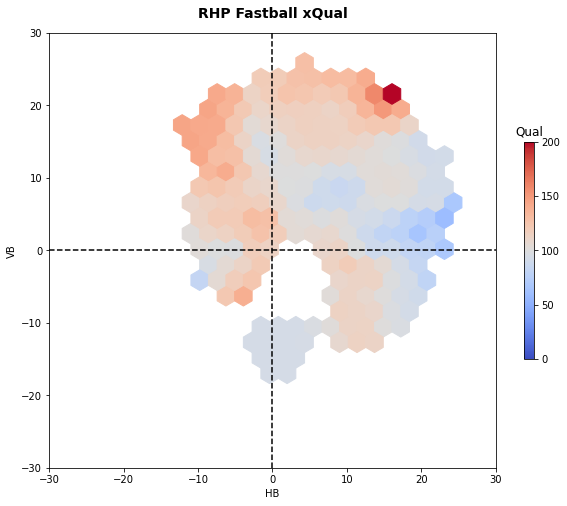

In [119]:
#plt.figure(figsize = (10, 8))
#plt.hexbin(fb_r_stats['pfx_x'], fb_r_stats['pfx_z'], C = fb_r_stats['Qual'], 
#           cmap = 'coolwarm', mincnt = 15, gridsize = 20)
#cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .5)
#cb.ax.set_title('Qual'), plt.clim(0, 200)
#plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
#plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
#plt.title('RHP Fastball Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(fb_r_stats['pfx_x'], fb_r_stats['pfx_z'], C = fb_r_stats['xQual'], 
           cmap = 'coolwarm', mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .5)
cb.ax.set_title('Qual'), plt.clim(0, 200)
#cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
#cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball xQual', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Fastball HB & VB xQual

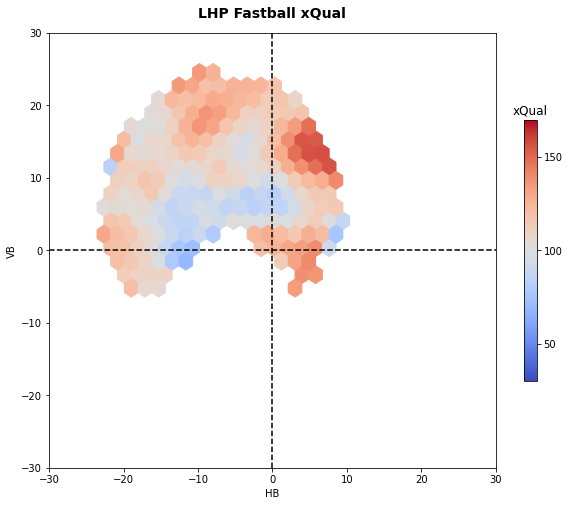

In [120]:
#plt.figure(figsize = (10, 8))
#plt.hexbin(fb_l_stats['pfx_x'], fb_l_stats['pfx_z'], C = fb_l_stats['Qual'], 
#           cmap = 'coolwarm', mincnt = 10, gridsize = 20)
#cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
#cb.ax.set_title('Qual'), plt.clim(30, 170)
#plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
#plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
#plt.title('LHP Fastball Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(fb_l_stats['pfx_x'], fb_l_stats['pfx_z'], C = fb_l_stats['xQual'], 
           cmap = 'coolwarm', mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Fastball xQual', fontsize = 14, fontweight = 'bold', pad = 15);

If we have a negative z-score the corresponding raw score should be less than the mean, and a positive z-score must correspond to a raw score higher than the mean.

## Breaking Ball
Slider, Curveball, Knuckle Curve

In [110]:
bb_r_stats = bb.loc[bb['p_throws'] == 'R']
bb_l_stats = bb.loc[bb['p_throws'] == 'L']

bb_r_avg = bb_r_stats.groupby(['pitch_type', 'p_throws'], 
                                          as_index = False, 
                                          sort = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                        'release_pos_z', 'release_extension'].mean()
bb_l_avg = bb_l_stats.groupby(['pitch_type', 'p_throws'], 
                                          as_index = False, 
                                          sort = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                        'release_pos_z', 'release_extension'].mean()
bb_avg = pd.concat([bb_r_avg, bb_l_avg], ignore_index = True)
bb_avg = bb_avg.round(1)
bb_avg.head(6)

,pitch_type,p_throws,velo,spin_rate,pfx_x,pfx_z,release_pos_z,release_extension
0,SL,R,84.9,2438.2,-6.3,1.8,5.8,6.3
1,CU,R,79.2,2538.3,-9.6,-9.3,6.0,6.2
2,KC,R,81.5,2575.8,-8.3,-11.7,5.9,6.3
3,SL,L,83.9,2357.1,5.8,1.5,5.9,6.2
4,CU,L,77.7,2439.9,8.4,-7.5,6.0,6.1
5,KC,L,78.9,2310.0,5.0,-9.0,6.3,6.0


In [111]:
bb[['rv', 'xRV']].describe()

,rv,xRV
count,207976.000000,207976.000000
mean,-0.007843,-0.005835
std,0.247489,0.140208
min,-1.860000,-1.124500
25%,0.000000,-0.029800
50%,0.000000,-0.006900
75%,0.000000,0.013900
max,3.760000,2.614700


## Breaking Ball Leaders

In [112]:
bb['RV/100'] = round(((bb['rv'] / (bb['CU_count'] + bb['SL_count'] + bb['KC_count'])) * 100), 2)
bb['xRV/100'] = round(((bb['xRV'] / (bb['CU_count'] + bb['SL_count'] + bb['KC_count'])) * 100), 2)

cols = list(bb[['rv', 'xRV', 'RV/100', 'xRV/100']])
bb[cols]

for col in cols:
    col_zscore = col + '_zscore'
    bb[col_zscore] = ((bb[col] - bb[col].mean())/ bb[col].std(ddof=0) * -1)

stats = bb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                       as_index = False)['SL_count', 'CU_count', 'KC_count', 
                                         'rv', 'xRV', 'rv_zscore', 'xRV_zscore'].sum()
bb = pd.merge(bb, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
bb['Qual'] = bb['rv_zscore_y'] + 100
bb['xQual'] = bb['xRV_zscore_y'] + 100
bb_r_stats = bb.loc[bb['p_throws'] == 'R']
bb_l_stats = bb.loc[bb['p_throws'] == 'L']

q_stats = bb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                                 as_index = False)['velo', 'pfx_x', 'pfx_z', 'RV/100', 
                                                   'xRV/100', 'Qual', 'xQual'].mean()

stats = pd.merge(stats, q_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
stats = stats.round(2)
stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'SL_count', 'CU_count', 'KC_count',
                                 'velo', 'pfx_x', 'pfx_z', 'rv', 'RV/100', 'Qual', 'xRV', 'xRV/100', 'xQual'])

bb_leaders = stats.sort_values(by = ['xQual'], ascending = False)
bb_leaders.head(10)

,player_name,p_throws,pitch_type,SL_count,CU_count,KC_count,velo,pfx_x,pfx_z,rv,RV/100,Qual,xRV,xRV/100,xQual
928,"Rodón, Carlos",L,SL,603.0,0.0,0.0,85.76,8.21,-1.06,-23.71,-3.93,176.69,-24.45,-4.05,249.28
1126,"Urías, Julio",L,CU,0.0,952.0,0.0,81.38,15.78,-0.93,-22.66,-2.38,161.39,-22.79,-2.39,222.89
935,"Rogers, Tyler",R,SL,479.0,0.0,0.0,71.76,-13.14,13.84,-22.02,-4.60,173.79,-19.43,-4.06,218.62
765,"Musgrove, Joe",R,CU,0.0,698.0,0.0,82.07,-11.02,-13.68,-19.70,-2.82,157.48,-19.97,-2.86,213.39
692,"McCullers Jr., Lance",R,SL,719.0,0.0,0.0,85.99,-13.67,4.59,-15.90,-2.21,141.46,-19.85,-2.76,211.65
1221,"deGrom, Jacob",R,SL,409.0,0.0,0.0,91.57,-4.67,3.46,-16.56,-4.05,153.95,-17.46,-4.27,207.48
1142,"Wainwright, Adam",R,CU,0.0,1027.0,0.0,73.47,-16.59,-14.75,-15.85,-1.54,131.50,-20.81,-2.03,205.68
690,"McClanahan, Shane",L,SL,674.0,0.0,0.0,89.15,3.79,2.03,-12.06,-1.79,127.37,-18.65,-2.77,204.94
521,"Jackson, Luke",R,SL,562.0,0.0,0.0,87.52,-1.40,-5.61,-16.78,-2.99,149.99,-17.94,-3.19,204.60
899,"Ray, Robbie",L,SL,964.0,0.0,0.0,88.62,0.98,7.16,-20.69,-2.15,153.05,-19.55,-2.03,199.29


In [113]:
bb[['Qual', 'xQual']].describe()

,Qual,xQual
count,207976.000000,207976.000000
mean,103.577767,107.083865
std,22.312383,39.874095
min,38.107847,-8.671043
25%,89.314814,83.082385
50%,102.231375,103.500641
75%,116.634628,128.095682
max,176.692996,249.282888


### RHP Breaking Ball HB & VB

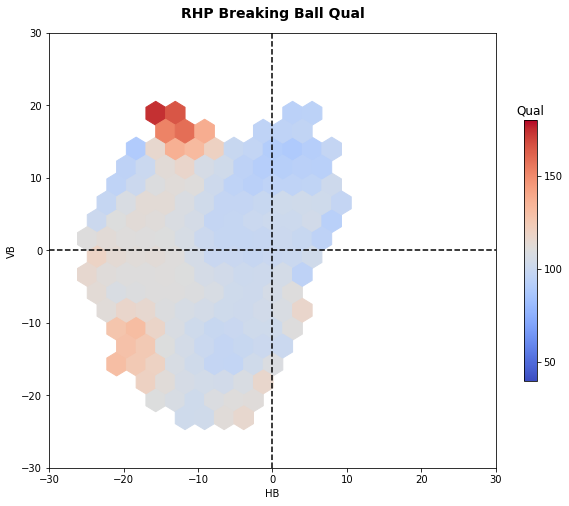

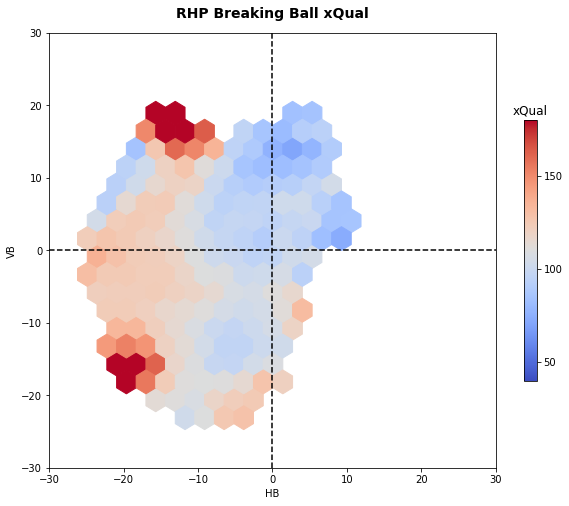

In [114]:
plt.figure(figsize = (10, 8))
plt.hexbin(bb_r_stats['pfx_x'], bb_r_stats['pfx_z'], C = bb_r_stats['Qual'], 
           cmap = 'coolwarm', mincnt = 15, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(40, 180)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Breaking Ball Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(bb_r_stats['pfx_x'], bb_r_stats['pfx_z'], C = bb_r_stats['xQual'], 
           cmap = 'coolwarm', mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(40, 180)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Breaking Ball xQual', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Breaking Ball HB & VB

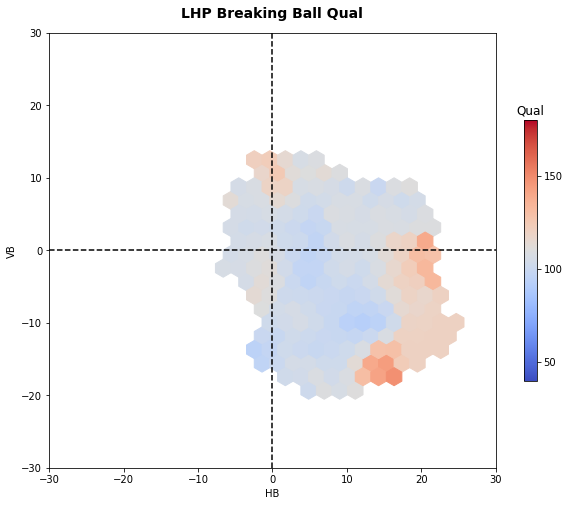

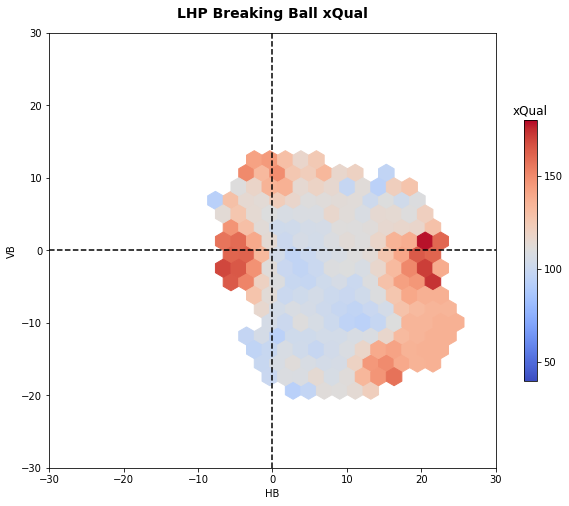

In [115]:
plt.figure(figsize = (10, 8))
plt.hexbin(bb_l_stats['pfx_x'], bb_l_stats['pfx_z'], C = bb_l_stats['Qual'], 
           cmap = 'coolwarm', mincnt = 15, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(40, 180)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Breaking Ball Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(bb_l_stats['pfx_x'], bb_l_stats['pfx_z'], C = bb_l_stats['xQual'], 
           cmap = 'coolwarm', mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(40, 180)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Breaking Ball xQual', fontsize = 14, fontweight = 'bold', pad = 15);

## Off-Speed
Changeup, Splitter

In [116]:
os_r_stats = os.loc[os['p_throws'] == 'R']
os_l_stats = os.loc[os['p_throws'] == 'L']

os_r_avg = os_r_stats.groupby(['pitch_type', 'p_throws'], 
                                          as_index = False, 
                                          sort = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                        'release_pos_z', 'release_extension'].mean()
os_l_avg = os_l_stats.groupby(['pitch_type', 'p_throws'], 
                                          as_index = False, 
                                          sort = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                        'release_pos_z', 'release_extension'].mean()
os_avg = pd.concat([os_r_avg, os_l_avg], ignore_index = True)
os_avg = os_avg.round(1)
os_avg.head(6)

KeyboardInterrupt: 

In [ ]:
os[['rv', 'xRV']].describe()

### Off-Speed Leaders

In [ ]:
os['RV/100'] = round(((os['rv'] / (os['CH_count'] + os['FS_count'])) * 100), 2)
os['xRV/100'] = round(((os['xRV'] / (os['CH_count'] + os['FS_count'])) * 100), 2)

cols = list(os[['rv', 'xRV', 'RV/100', 'xRV/100']])
os[cols]

for col in cols:
    col_zscore = col + '_zscore'
    os[col_zscore] = ((os[col] - os[col].mean()) / os[col].std(ddof=0) * -1)

stats = os.groupby(['player_name', 'p_throws', 'pitch_type'], 
                       as_index = False)['CH_count', 'FS_count', 'rv', 'xRV', 
                                         'rv_zscore', 'xRV_zscore'].sum()
os = pd.merge(os, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
os['Qual'] = os['rv_zscore_y'] + 100
os['xQual'] = os['xRV_zscore_y'] + 100
os_r_stats = os.loc[os['p_throws'] == 'R']
os_l_stats = os.loc[os['p_throws'] == 'L']

q_stats = os.groupby(['player_name', 'p_throws', 'pitch_type'], 
                     as_index = False)['velo', 'pfx_x', 'pfx_z', 'RV/100', 
                                       'xRV/100', 'Qual', 'xQual'].mean()

stats = pd.merge(stats, q_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
stats = stats.round(2)
stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'CH_count', 'FS_count', 'velo', 
                                 'pfx_x', 'pfx_z', 'rv', 'RV/100', 'Qual', 'xRV', 'xRV/100', 'xQual'])

os_leaders = stats.sort_values(by = ['xQual'], ascending = False)
os_leaders.head(10)

In [ ]:
os[['Qual', 'xQual']].describe()

### RHP Off-Speed HB & VB

In [ ]:
plt.figure(figsize = (10, 8))
plt.hexbin(os_r_stats['pfx_x'], os_r_stats['pfx_z'], C = os_r_stats['Qual'], 
           cmap = 'coolwarm', mincnt = 15, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(40, 180)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Off-Speed Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(os_r_stats['pfx_x'], os_r_stats['pfx_z'], C = os_r_stats['xQual'], 
           cmap = 'coolwarm', mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(40, 180)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Off-Speed xQual', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Off-Speed HB & VB

In [ ]:
plt.figure(figsize = (10, 8))
plt.hexbin(os_l_stats['pfx_x'], os_l_stats['pfx_z'], C = os_l_stats['Qual'], 
           cmap = 'coolwarm', mincnt = 15, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Off-Speed Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(os_l_stats['pfx_x'], os_l_stats['pfx_z'], C = os_l_stats['xQual'], 
           cmap = 'coolwarm', mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Off-Speed xQual', fontsize = 14, fontweight = 'bold', pad = 15);

# Save to CSV

In [ ]:
pitch_quality = pd.concat([fb, bb, os], ignore_index = True)
#pitch_quality.to_csv('../data/pitch-quality.csv')

In [ ]:
print(pitch_quality.shape)
pitch_quality.head()